# LangChain

### 학습 목표
1. LangChain의 기본 사용법에 대해 알아보자.
2. LangChain을 활용해 보자.

### context
1. LangChain 기본 활용법
2. Zero-shot CoT
3. Search & Summarize application

## 0. LangChain이란?

대형언어모델(Large Language Model, LLM)이 뛰어난 성능이 보여주며, 이를 활용한 다양한 Application이 개발되고 있다. 하지만 LLM을 활용하여 애플리케이션을 개발하는 것은 단순히 사용자의 프롬프트를 입력받고, LLM의 응답을 출력하는 것 이상의 복잡한 과정을 포함한다.

LangChain은 LLM을 기반으로 애플리케이션을 구축하기 위한 오픈 소스 프레임워크이다. 우리는 LangChain을 통해 복잡한 과정 없이 LLM을 애플리케이션에 통합할 수 있다.

본 실습에선 앞 실습에서 다루었던 Zero-shot CoT가 어떻게 LangChain으로 간소화될 수 있는지 알아보고, 사용자의 질문을 검색한 이후 결과를 요약하여 출력하는 간단한 애플리케이션을 만들어볼 것이다.

## 1. LangChain의 기본 사용법

In [1]:
!pip install -q "langchain>=0.0.352" "openai>=1.3.4" "tiktoken>=0.5.2" "duckduckgo_search==5.3.1b1" "transformers>=4.35.2" "accelerate>=0.24.1" "bitsandbytes>=0.41.2" "sentencepiece>=0.1.99" "torch>=2.1.0" "langchain-openai>=0.0.2" "langchainhub>=0.1.14"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 617.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.6/990.6 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.7/336.7 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.9/379.9 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.2/140.2 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0

### 사용할 모델 선정

LangChain은 기본적으로 OpenAI 기반 서비스에 최적화 되어있다. 그렇다고 Llama2와 같은 오픈 소스 모델을 사용할 수 없는 것은 아니다.

#### GPT-3.5 turbo

In [2]:
OPENAI_API_KEY = "여기에 OPENAI_API_KEY를 입력하세요."

In [3]:
from langchain_openai import OpenAI
import tiktoken

llm = OpenAI(
    openai_api_key=OPENAI_API_KEY,
    model_name='gpt-3.5-turbo-instruct'
)

tokenizer = tiktoken.get_encoding("cl100k_base")

#### Llama2

In [ ]:
import torch
from transformers import BitsAndBytesConfig
from langchain_community.llms.huggingface_pipeline import HuggingFacePipeline

llm = HuggingFacePipeline.from_model_id( # Langchain에서도 모델 생성을 도와줄 Pipeline을 지원한다.
    model_id="NousResearch/Llama-2-13b-chat-hf",
    task="text-generation",
    model_kwargs={
        "quantization_config": BitsAndBytesConfig(
            load_in_4bit=True, # 4bit로 quantization하여 모델을 불러온다.
            bnb_4bit_compute_dtype=torch.float16
        )
    },
    pipeline_kwargs={
        "max_new_tokens": 1024,
        "do_sample": True,
        "temperature": 0.01,
        "top_p": 0.9,
        "repetition_penalty": 1.15 # 반복을 통제할 수 있다.
    }
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/33.4k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/9.90G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/6.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/175 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:386: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


### invoke & batch

위 두 메소드를 통해 모델의 응답을 출력할 수 있다.

In [4]:
llm.invoke("Bibimbap is the food of")

' the gods. It is the perfect food, a complete meal in a bowl. It is a harmony of flavors, textures, and colors, and it is a staple in Korean cuisine. Bibimbap literally means "mixed rice," and it is a dish made up of rice, vegetables, meat, and a fried egg, all mixed together with a spicy sauce.\n\nThe origin of bibimbap can be traced back to the Joseon Dynasty in Korea, where it was considered a royal dish. It was also a popular dish among farmers, who would mix leftover vegetables and rice together for a hearty and nutritious meal.\n\nToday, bibimbap is a beloved and iconic dish in Korea and is enjoyed by people all over the world. It is also a versatile dish, as it can be customized with a variety of ingredients to suit different tastes and dietary restrictions.\n\nTo make bibimbap, a bowl is first filled with steamed rice, which serves as the base of the dish. Then, a variety of vegetables such as carrots, spinach, bean sprouts, and cucumbers are added, along with a protein such a

In [5]:
llm.batch(["Bibimbap is the food of ", "Sushi is the food of"])

['2017. With its healthy ingredients and delicious taste, it has taken the culinary world by storm. But what exactly is bibimbap and why is everyone talking about it?\n\nBibimbap is a Korean dish that literally translates to "mixed rice." It is a bowl of rice topped with various vegetables, meat, and a fried egg. The ingredients are arranged in separate sections on top of the rice, and then mixed together with a spicy sauce called gochujang. The result is a flavorful and colorful bowl of goodness.\n\nThe dish originated in Jeonju, a city in South Korea, and has been a staple in Korean cuisine for centuries. However, it has gained popularity in recent years due to its healthy and balanced ingredients. Bibimbap typically includes a variety of vegetables such as carrots, spinach, mushrooms, and bean sprouts, as well as protein sources like beef, chicken, or tofu. It is also often served with a side of kimchi, a fermented cabbage dish that is a staple in Korean cuisine.\n\nIn addition to i

### PromptTemplate

LangChain은 PromptTemplate을 만들어 대형언어모델이 해당 프롬프트에 따른 답변을 생성할 수 있도록 한다.

In [6]:
from langchain.prompts import PromptTemplate

template = """\
Question: {question}
Answer: \
"""

prompt = PromptTemplate.from_template(template)

In [7]:
prompt.invoke({"question": "What is the most famous food in South Korea?"})

StringPromptValue(text='Question: What is the most famous food in South Korea?\nAnswer: ')

In [8]:
prompt.batch([
    {"question": "What is the most famous food in South Korea?"},
    {"question": "What is the most famous food in Japan?"}
])

[StringPromptValue(text='Question: What is the most famous food in South Korea?\nAnswer: '),
 StringPromptValue(text='Question: What is the most famous food in Japan?\nAnswer: ')]

### LangChain Expression Language (LCEL)

LCEL은 체인을 쉽게 구성할 수 있는 선언 방식이다. LCEL을 통해 Prompt를 LLM에게 전달하고, 복잡한 기능을 하는 체인까지 만들 수 있다. 앞서 다룬 llm과 prompt를 chain으로 연결해 보자.

In [9]:
llm_prompt = prompt | llm

In [10]:
llm_prompt.invoke({"question": "What is the most famous food in South Korea?"}) # 입력을 prompt로 전달하고, prompt를 llm에게 전달한다.

'Kimchi is considered the most famous food in South Korea.'

In [11]:
llm_prompt.batch([
    {"question": "What is the most famous food in South Korea?"},
    {"question": "What is the most famous food in Japan?"}
])

['Kimchi is considered the most famous food in South Korea. It is a spicy and sour fermented side dish made with vegetables, most commonly cabbage. It is a staple in Korean cuisine and is served with almost every meal. ',
 'Sushi is often considered the most famous food in Japan.']

아래 예시처럼 일반적인 파이썬 함수를 연결할 수도 있다.

In [12]:
llm_prompt = prompt | llm | str.split

In [13]:
llm_prompt.batch([
    {"question": "What is the most famous food in South Korea?"},
    {"question": "What is the most famous food in Japan?"}
])

[['Kimchi',
  'is',
  'considered',
  'the',
  'most',
  'famous',
  'food',
  'in',
  'South',
  'Korea.',
  'It',
  'is',
  'a',
  'traditional',
  'dish',
  'made',
  'of',
  'fermented',
  'vegetables,',
  'usually',
  'cabbage',
  'and',
  'radish,',
  'seasoned',
  'with',
  'spices',
  'and',
  'chili',
  'peppers.',
  'It',
  'is',
  'served',
  'with',
  'almost',
  'every',
  'meal',
  'and',
  'is',
  'a',
  'staple',
  'in',
  'Korean',
  'cuisine.'],
 ['Sushi',
  'is',
  'considered',
  'the',
  'most',
  'famous',
  'food',
  'in',
  'Japan.']]

## LangChain의 활용

LangChain의 기초 사용법에 대해 알아보았다. LangChain을 통해 LLM을 직관적으로 사용할 수 있고, 애플리케이션에 LLM을 통합하는 것이 간단해질 수 있음을 느꼈을 것이다.

아래 실습에서 Zero-shot CoT로 출력된 모델의 응답을 수학적인 변수(x,y,z)를 통해 설명하는 애플리케이션을 구현해 보자.

### Zero-shot CoT

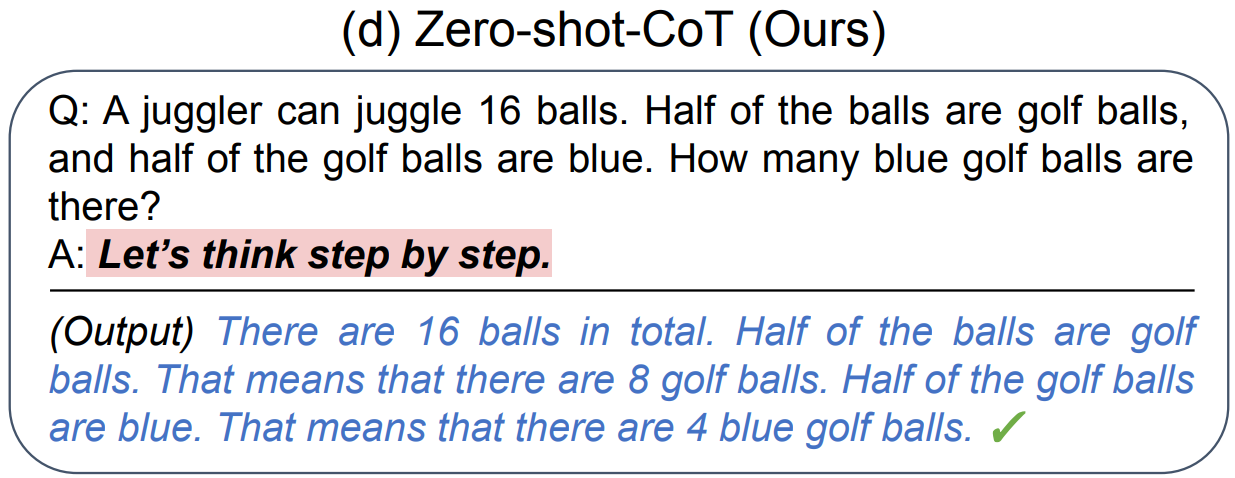

In [14]:
from langchain_core.runnables import RunnablePassthrough
from langchain.prompts import PromptTemplate

zeroshot_cot_template = """\
Question: {question}
Answer: Let's think step by step.\
"""

rewrite_template = """\
Rewrite the input with variables.
Input: {input}\
"""

zeroshot_cot_prompt = PromptTemplate.from_template(zeroshot_cot_template) # Zeroshot CoT를 위한 프롬프트
rewrite_prompt = PromptTemplate.from_template(rewrite_template) # Zeroshot CoT의 결과를 수학적인 변수 기반으로 바꾸는 프롬프트

zeroshot_cot = zeroshot_cot_prompt | llm # 비교를 위한 체인

# Data를 그대로 넘겨주거나 kwargs를 추가하여 넘겨주려면, RunnablePassthrough를 사용한다.
zeroshot_cot_rewrite = (
    {"question": RunnablePassthrough()} # 사용자의 입력을 특정 key(question)에 할당한다.
    | RunnablePassthrough.assign( # RunnablePassthrough.assign을 통해 zeroshot_cot_prompt | llm 체인의 결과를 특정 key(input)에 할당한다.
        input = zeroshot_cot_prompt | llm,
    )
    | rewrite_prompt
    | llm
)

# 아래 chain을 사용해도 동일한 효과를 기대할 수 있다.
# zeroshot_cot_rewrite = (
#     {"question": RunnablePassthrough()} # 사용자의 입력을 특정 key(question)에 할당한다.
#     | {"input" : zeroshot_cot_prompt | llm} # zeroshot_cot_prompt | llm 체인의 결과를 특정 key(input)에 할당한다.
#     | rewrite_prompt
#     | llm
# )

In [15]:
output1 = zeroshot_cot.batch([
    {"question": "Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?"},
    {"question": "The cafeteria had 325 apples. If they consume 23 for lunch and 37 for dinner each day, how many will be left after 3 days?"}
])
print("Answer1: ", output1[0])
print("-----")
print("Answer2: ", output1[1])

Answer1:   In April, Natalia sold 48 clips. Then, in May, she sold half as many clips. This means she sold 48/2 = 24 clips in May. To find the total number of clips sold in April and May, we add 48 and 24 together. Therefore, Natalia sold 48+24 = 72 clips altogether in April and May.
-----
Answer2:   
1) First, let's find out how many apples will be consumed in one day. 
23 apples + 37 apples = 60 apples consumed per day
2) Next, we need to find out how many apples will be consumed in 3 days. 
60 apples consumed per day x 3 days = 180 apples consumed in 3 days
3) Finally, we can subtract the number of apples consumed in 3 days from the total number of apples to find out how many will be left. 
325 apples - 180 apples = 145 apples will be left after 3 days.


In [16]:

output2 = zeroshot_cot_rewrite.batch([
    {"question": "Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?"},
    {"question": "The cafeteria had 325 apples. If they consume 23 for lunch and 37 for dinner each day, how many will be left after 3 days?"}
])
print("Answer1: ", output2[0])
print("-----")
print("Answer2: ", output2[1])

Answer1:  

Let n be the total number of clips sold by Natalia in April and May.
Let a be the number of clips sold by Natalia in April.
Let m be the number of clips sold by Natalia in May.

1. First, we know that Natalia sold clips to 48 friends in April. 
2. Then, we know that she sold half as many clips in May, which would be m = a/2. 
3. So, in April, she sold a = 48 clips. 
4. In May, she sold m = 24 clips. 
5. To find the total number of clips she sold in April and May, we need to add these two numbers together: n = a + m = 48 + 24 = 72. 
6. Natalia sold n = 72 clips altogether in April and May.
-----
Answer2:  

Let a be the initial number of apples in the cafeteria.
After day 1, there will be (a - 23 - 37) apples left.
On day 2, there will be ((a - 23 - 37) - 23 - 37) apples left.
Finally, on day 3, there will be (((a - 23 - 37) - 23 - 37) - 23 - 37) apples left.
Therefore, after 3 days, there will be (((a - 23 - 37) - 23 - 37) - 23 - 37) apples left in the cafeteria.


### Search & Summarize

사용자의 쿼리에 대해, 검색 엔진의 결과를 5문장으로 요약하여 출력하는 애플리케이션을 구현해 보자.

In [18]:
from duckduckgo_search import DDGS
import json

def web_search(query: str):
    with DDGS() as ddgs:
        return [r for r in ddgs.text(query, max_results=5)]

def get_body(search_result):
    return search_result[0]["body"] + " " + search_result[1]["body"] + " " + search_result[2]["body"]

result = web_search(query="How can I cook Bibimbap?")
print(result)

[{'title': 'Bibimbap recipe| Korean Bapsang', 'href': 'https://www.koreanbapsang.com/bibimbap/', 'body': 'Place a serving of rice in a big bowl. Nicely arrange a small amount of each prepared vegetable and beef over the rice. Drizzle a little sesame oil over. Top with an optional fried egg and serve with the sauce. For dolsot bibimbap: Lightly oil a stone or earthenware bowl with a teaspoon of sesame oil over medium heat.'}, {'title': 'Bibimbap (Mixed rice with vegetables) recipe by Maangchi', 'href': 'https://www.maangchi.com/recipe/bibimbap', 'body': 'Divide the rice among the bowls. Arrange the vegetables and beef on the rice. Top each serving with a raw egg yolk and 1 tablespoon gochujang. If you prefer your eggs and beef cooked, use a fried egg sunny side up and slightly pan-fry the beef before putting them on the top of rice. Set each pot on a burner.'}, {'title': 'Easy Korean Beef Bibimbap Recipe - The Woks of Life', 'href': 'https://thewoksoflife.com/easy-beef-bibimbap-recipe/'

In [19]:
from langchain_core.runnables import RunnableLambda
from langchain.prompts import PromptTemplate
from operator import itemgetter

summarize_template = """\
Summarize below document with 5 sentences.
Document : {document}\
"""

summarize_prompt = PromptTemplate.from_template(summarize_template)

search_summarize_chain = (
     itemgetter("query")
     | RunnableLambda(web_search) # RunnableLambda를 통해 사전에 정의한 함수를 사용할 수 있다.
     | RunnableLambda(get_body)
     | {"document": RunnablePassthrough()}
     | summarize_prompt
     | llm
)

In [20]:
output = search_summarize_chain.batch([
    {"query": "How can I cook Bibimbap?"},
    {"query": "How can I cook Sushi?"}
])

print("Answer1: ", output[0])
print("Answer2: ", output[1])

Answer1:  

1. The document provides instructions for making a dish called bibimbap.
2. It involves placing rice in a bowl and arranging vegetables and beef on top.
3. Sesame oil is used as a drizzle and the dish can be topped with a fried egg.
4. For a different version, the rice is cooked in a stone bowl and topped with raw egg yolk and gochujang.
5. The vegetables are seasoned with salt and sesame oil, along with minced garlic.
Answer2:  

Sushi is a popular Japanese dish that is eaten worldwide. To make sushi at home, you will need to get the necessary ingredients from a grocery store or market. A bamboo sushi mat, nori sheets, and sushi seasoning are essential items for making sushi. While it is possible to make your own sushi seasoning, it is recommended to use store-bought for beginners. There are many sushi recipes available, including California roll, classic nigiri, and temaki hand roll, that you can try making at home.


## ChatAPI 사용하기

> Completion API vs Chat API

Completion API는 의미 그대로 문장을 "완성"하기 위한 API이다. 즉 문자열 *Bibimbap is the food of* 을 모델에게 전달하면, 모델은 디코딩 전략에 따라 다음 토큰들을 생성하며 문장을 완성한다.

Chat API는 Assistant(언어 모델)와 User(사용자)의 대화에 중점을 두는 API이다. 해당 API는 3가지의 role인 *System*, *Assistant*, *User*로 텍스트를 입력할 수 있다. 또한 이전 대화 내역의 role을 기반으로 양질의 답변을 기대할 수 있다.

위 LangChain을 위한 실습에선 Completion API를 사용하였다. 이제 LangChain을 통해 ChatAPI를 사용해 보자.

* 본 섹션에선 OpenAI API만을 사용할 것이다.

In [21]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_openai import ChatOpenAI

In [22]:
OPENAI_API_KEY = "여기에 OPENAI_API_KEY를 입력하세요."

In [23]:
chat = ChatOpenAI(openai_api_key=OPENAI_API_KEY)

In [24]:
dir(chat)

['Config',
 'InputType',
 'OutputType',
 '__abstractmethods__',
 '__annotations__',
 '__call__',
 '__class__',
 '__class_getitem__',
 '__class_vars__',
 '__config__',
 '__custom_root_type__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__exclude_fields__',
 '__fields__',
 '__fields_set__',
 '__format__',
 '__ge__',
 '__get_validators__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__include_fields__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__json_encoder__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__or__',
 '__orig_bases__',
 '__parameters__',
 '__post_root_validators__',
 '__pre_root_validators__',
 '__pretty__',
 '__private_attributes__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__repr_args__',
 '__repr_name__',
 '__repr_str__',
 '__rich_repr__',
 '__ror__',
 '__schema_cache__',
 '__setattr__',
 '__setstate__',
 '__signature__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__try_updat

In [25]:
print(chat.name)

None


In [26]:
messages = [
    SystemMessage( # role중 system이다. system 메세지를 통해 질문에 대한 모델의 응답 방식을 지정하거나 페르소나를 입힐 수 있다.
        content="You are a helpful assistant that translates English to Korean."
    ),
    HumanMessage( # role 중 user이다. 사용자의 입력이 들어가는 부분이다.
        content="I love programming."
    ),
]
response = chat(messages)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [27]:
print(response)

content='나는 프로그래밍을 사랑해요.' response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 26, 'total_tokens': 40}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run-a0130648-6ed3-4e2b-891c-659049ab96a5-0' usage_metadata={'input_tokens': 26, 'output_tokens': 14, 'total_tokens': 40}


### ChatAPI를 통한 In context Learning

앞선 실습에선 In context Learning을 Completion 형태로 해왔다. 즉 아래와 같다.
```
Analyze the sentiment of a sentence:
I don't like watching movies. => Negative
That restaurant was amazing. => Positive
Pizza is delicious. => Positive
This movie is terrible. =>
```
본 섹션에선 In context Learning을 Chat 형태로 수행할 것이다. 위 예제를 아래와 같은 형태로 사용할 것이다.
```
[System] Analyze the sentiment of a sentence:
[User] I don't like watching movies.
[Assistant] Negative
[User] That restaurant was amazing.
[Assistant] Positive
[User] Pizza is delicious.
[Assistant] Positive
[User] This movie is terrible.
```
위 형태는 예시이며, 실제 OpenAI의 role에 따른 프롬프트 형태는 알 수 없다.

#### Role에 따른 세 가지 메세지

LangChain에서는 Human과 AI라는 용어를 사용하지만, OpenAI에서 사용하는 정식 명칭은 User와 Assistant임을 알아두자.

In [28]:
messages = [
    SystemMessage(
        content="You are a helpful assistant that analyzes the sentiment for given sentence."
    ),
    HumanMessage(
        content="I don't like watching movies."
    ),
    AIMessage( # Assistant의 응답
        content="Negative"
    ),
    HumanMessage(
        content="That restaurant was amazing."
    ),
    AIMessage(
        content="Positive"
    ),
    HumanMessage(
        content="Pizza is delicious."
    ),
    AIMessage(
        content="Positive"
    ),
    HumanMessage(
        content="This movie is terrible."
    )
]
response = chat(messages)

In [29]:
print(response)

content='Negative' response_metadata={'token_usage': {'completion_tokens': 1, 'prompt_tokens': 72, 'total_tokens': 73}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run-456cae20-41f4-48b1-9b2e-81b96f52aade-0' usage_metadata={'input_tokens': 72, 'output_tokens': 1, 'total_tokens': 73}


#### FewShotChatMessagePromptTemplate

LangChain에서 지원하는 [FewShotChatMessagePromptTemplate](https://api.python.langchain.com/en/latest/prompts/langchain_core.prompts.few_shot.FewShotChatMessagePromptTemplate.html)를 통해 Chat형태로 In context learning을 더 쉽게 사용할 수 있다.

In [30]:
from langchain.prompts.chat import ChatPromptTemplate
from langchain.prompts.few_shot import FewShotChatMessagePromptTemplate

In [31]:
# In context example에 들어갈 예제들을 정의한다.
examples = [
    {"input": "I don't like watching movies.", "output": "Negative"},
    {"input": "That restaurant was amazing.", "output": "Positive"},
    {"input": "Pizza is delicious.", "output": "Positive"}
]

# 각 example에 대한 prompt template을 정의한다.
example_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}"),
        ("ai", "{output}"),
    ]
)

# 정의한 example_prompt에 예제들을 입력한다.
demonstration_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=examples,
)

print(demonstration_prompt.format())

Human: I don't like watching movies.
AI: Negative
Human: That restaurant was amazing.
AI: Positive
Human: Pizza is delicious.
AI: Positive


In [32]:
# 정의한 demonstration_prompt의 위와 아래에 system과 user message를 각각 더해준다.
few_shot_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful assistant that analyzes the sentiment for given sentence."), # system message
        demonstration_prompt,
        ("human", "{input}"), # user message
    ]
)

user_input = "#Here is user input#"
print(few_shot_prompt.format(input=user_input))

System: You are a helpful assistant that analyzes the sentiment for given sentence.
Human: I don't like watching movies.
AI: Negative
Human: That restaurant was amazing.
AI: Positive
Human: Pizza is delicious.
AI: Positive
Human: #Here is user input#


In [33]:
few_shot_chain = few_shot_prompt | chat # input을 few_shot_prompt에 할당한 이후 chat model에 전달하는 chain을 정의한다.

In [34]:
print(few_shot_chain.invoke({"input": "This movie is terrible."}))

content='Negative' response_metadata={'token_usage': {'completion_tokens': 1, 'prompt_tokens': 72, 'total_tokens': 73}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run-9e0c3368-4b00-4e3e-be6a-81fb1a05adf9-0' usage_metadata={'input_tokens': 72, 'output_tokens': 1, 'total_tokens': 73}


## Reference
1. https://github.com/langchain-ai
2. https://python.langchain.com/docs/get_started/introduction